gofasta vs amanual mutation calling

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

In [51]:
hu1_gofasta_path = '/home/eleanor124/projects/bjorn_rep/output/Hu1/gofasta/mutations.tsv'
hu1_manual_path = '/home/eleanor124/projects/bjorn_rep/output/Hu1/mutations.tsv'

ba1_gofasta_path = '/home/eleanor124/projects/bjorn_rep/output/Hu1/gofasta/BA1/mutations.tsv'
ba1_manual_path = '/home/eleanor124/projects/bjorn_rep/output/Hu1/NC_045512.2_BA.1_mutations.tsv'

ba2_gofasta_path = '/home/eleanor124/projects/bjorn_rep/output/Hu1/gofasta/BA2/mutations.tsv'
ba2_manual_path = '/home/eleanor124/projects/bjorn_rep/output/Hu1/NC_045512.2_BA.2_mutations.tsv'


pb2_gofasta_path = '/home/eleanor124/projects/bjorn_rep/output/PB2/gofasta/mutations.tsv'
pb2_manual_path = '/home/eleanor124/projects/bjorn_rep/output/PB2/mutations.tsv'

cy_gofasta_path = '/home/eleanor124/projects/bjorn_rep/output/PB2/gofasta/CY/mutations.tsv'
cy_manual_path = '/home/eleanor124/projects/bjorn_rep/output/PB2/CY018884.1_cds_ABM21959.1_1_mutations.tsv'

In [41]:
ambiguous_nuc = ['R', 'Y', 'W', 'S', 'K', 'M', 'B', 'D', 'H', 'V', 'N']

In [42]:
def process(path):
    df = pd.read_csv(path, sep="\t")
    df = (
        df[["sra", "region", "pos", "ref", "alt"]]
        .drop_duplicates()
        .sort_values(by=["sra", "pos"])
        .reset_index(drop=True)
    )

    return df


In [43]:
def corr_plt(gofasta, manual, title):

    gofasta1 = (
        gofasta.groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_gofasta")
    )

    manual2 = (
        manual[~manual["alt"].isin(ambiguous_nuc)]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_manual")
    )
    
    merged2 = pd.merge(gofasta1, manual2, on='sra', how="outer").fillna(0)

    plt.scatter(merged2['pos_count_manual'], merged2['pos_count_gofasta'], color='lightblue')
    minv = min(merged2['pos_count_manual'])
    maxv = max(merged2['pos_count_manual'])
    
    plt.plot([minv, maxv], [minv, maxv], 'r--', label='y = x')
    plt.legend(loc='upper right')
    plt.xlabel("pos count - our mutation calling")
    plt.ylabel("pos count - gofasta")
    plt.title("Number of mutation positions from 2 callings, excluding ambiguous nuc for ALT")
    plt.tight_layout()
    plt.show()

    return merged2[merged2['pos_count_gofasta'] != merged2['pos_count_manual']]


## Hu1-BA

In [52]:
hu1_gofasta = process(hu1_gofasta_path)
ba1_gofasta = process(ba1_gofasta_path)
ba2_gofasta = process(ba2_gofasta_path)

hu1_manual = process(hu1_manual_path)
ba1_manual = process(ba1_manual_path)
ba2_manual = process(ba2_manual_path)

/tmp/ipykernel_75877/106381375.py:2: DtypeWarning: Columns (5,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep="\t")
/tmp/ipykernel_75877/106381375.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep="\t")


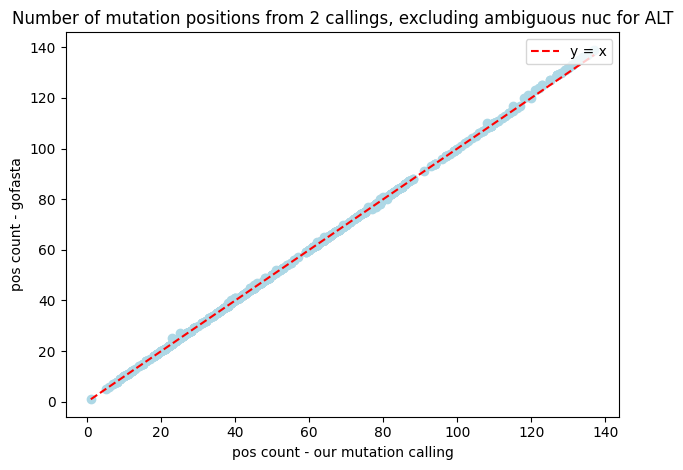

,sra,pos_count_gofasta,pos_count_manual,gap
288,hCoV-19/USA/CA-SEARCH-201359/2022,76,77,1
284,hCoV-19/USA/CA-SEARCH-201075/2022,77,78,1
316,hCoV-19/USA/CA-SEARCH-214489/2022,78,79,1
325,hCoV-19/USA/CA-SEARCH-219082/2022,80,81,1
313,hCoV-19/USA/CA-SEARCH-213047/2022,78,79,1
901,hCoV-19/USA/STM-EN8263XGH/2021,47,46,-1
794,hCoV-19/USA/STM-0007200-H10/2021,45,44,-1
946,hCoV-19/USA/STM-QF72HJ7XG/2022,81,80,-1
939,hCoV-19/USA/STM-NY8R7RPYP/2021,52,51,-1
758,hCoV-19/USA/STM-0000503-B02/2021,39,38,-1


In [53]:
pos_mismatch = corr_plt(hu1_gofasta, hu1_manual, "Hu-1")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_gofasta"]
pos_mismatch.sort_values(by=["gap"], ascending=False)

In [ ]:
tmp1 = hu1_gofasta.loc[hu1_gofasta["sra"] == "hCoV-19/USA/CA-SEARCH-63567/2021", ]
tmp2 = hu1_manual.loc[(hu1_manual["sra"] == "hCoV-19/USA/CA-SEARCH-63567/2021") & (hu1_manual["alt"] != 'N'), ]
pd.merge(tmp1, tmp2, how="outer", on=['sra', 'pos'])

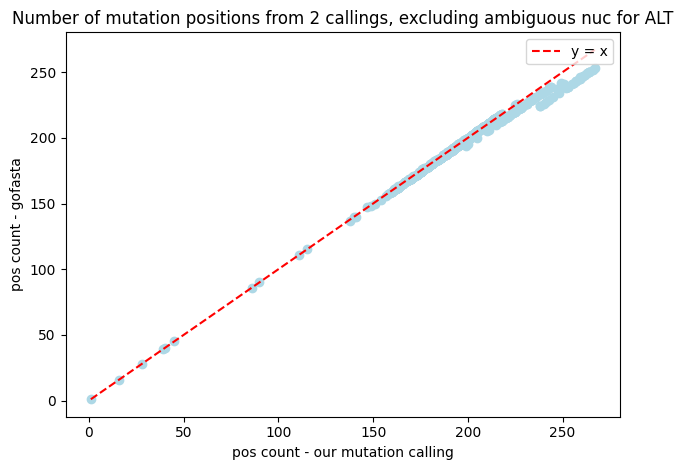

,sra,pos_count_gofasta,pos_count_manual,gap
268,hCoV-19/USA/CA-SEARCH-140651/2024,239,253,14
281,hCoV-19/USA/CA-SEARCH-142947/2024,250,264,14
278,hCoV-19/USA/CA-SEARCH-142214/2024,245,259,14
277,hCoV-19/USA/CA-SEARCH-141694/2024,249,263,14
276,hCoV-19/USA/CA-SEARCH-141470/2024,246,260,14
...,...,...,...,...
416,hCoV-19/USA/CA-SEARCH-60740/2021,196,197,1
417,hCoV-19/USA/CA-SEARCH-61615/2021,183,184,1
418,hCoV-19/USA/CA-SEARCH-61656/2021,184,185,1
419,hCoV-19/USA/CA-SEARCH-61672/2021,183,184,1


In [54]:
pos_mismatch = corr_plt(ba1_gofasta, ba1_manual, "BA1")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_gofasta"]
pos_mismatch.sort_values(by=["gap"], ascending=False)

In [37]:
tmp1 = ba1_gofasta[(ba1_gofasta["sra"] == "hCoV-19/USA/CA-SEARCH-233687/2024") & (~ba1_gofasta["alt"].isin(ambiguous_nuc))]
tmp2 = ba1_manual[(ba1_manual["sra"] == 'hCoV-19/USA/CA-SEARCH-233687/2024') & (~ba1_manual["alt"].isin(ambiguous_nuc))]
m = pd.merge(tmp1, tmp2, how="outer", on=["pos"], indicator=True)
m[m["_merge"] != "both"]

,sra_x,region_x,pos,ref_x,alt_x,sra_y,region_y,ref_y,alt_y,_merge
123,hCoV-19/USA/CA-SEARCH-233687/2024,NC_045512.2_BA.1,22929,T,-C,NaN,NaN,NaN,NaN,left_only
144,hCoV-19/USA/CA-SEARCH-233687/2024,NC_045512.2_BA.1,23008,C,G,NaN,NaN,NaN,NaN,left_only
226,NaN,NaN,22895,NaN,NaN,hCoV-19/USA/CA-SEARCH-233687/2024,NC_045512.2,G,C,right_only
227,NaN,NaN,22897,NaN,NaN,hCoV-19/USA/CA-SEARCH-233687/2024,NC_045512.2,C,T,right_only
228,NaN,NaN,22898,NaN,NaN,hCoV-19/USA/CA-SEARCH-233687/2024,NC_045512.2,T,A,right_only
229,NaN,NaN,22899,NaN,NaN,hCoV-19/USA/CA-SEARCH-233687/2024,NC_045512.2,C,G,right_only
230,NaN,NaN,22900,NaN,NaN,hCoV-19/USA/CA-SEARCH-233687/2024,NC_045512.2,A,T,right_only
231,NaN,NaN,22924,NaN,NaN,hCoV-19/USA/CA-SEARCH-233687/2024,NC_045512.2,T,A,right_only
232,NaN,NaN,22925,NaN,NaN,hCoV-19/USA/CA-SEARCH-233687/2024,NC_045512.2,C,T,right_only
233,NaN,NaN,22927,NaN,NaN,hCoV-19/USA/CA-SEARCH-233687/2024,NC_045512.2,T,G,right_only


In [19]:
ba1_manual[(ba1_manual["sra"] == 'hCoV-19/USA/STM-0007062-B10/2021') & (~ba1_manual["alt"].isin(ambiguous_nuc))]

,sra,region,pos,ref,alt
359326,hCoV-19/USA/STM-0007062-B10/2021,NC_045512.2,22555,C,T
359329,hCoV-19/USA/STM-0007062-B10/2021,NC_045512.2,22558,A,T
359338,hCoV-19/USA/STM-0007062-B10/2021,NC_045512.2,22567,A,G
359344,hCoV-19/USA/STM-0007062-B10/2021,NC_045512.2,22573,C,T
359349,hCoV-19/USA/STM-0007062-B10/2021,NC_045512.2,22578,A,G
...,...,...,...,...,...
359899,hCoV-19/USA/STM-0007062-B10/2021,NC_045512.2,23128,T,A
359902,hCoV-19/USA/STM-0007062-B10/2021,NC_045512.2,23131,G,T
359911,hCoV-19/USA/STM-0007062-B10/2021,NC_045512.2,23140,T,A
359917,hCoV-19/USA/STM-0007062-B10/2021,NC_045512.2,23146,G,A


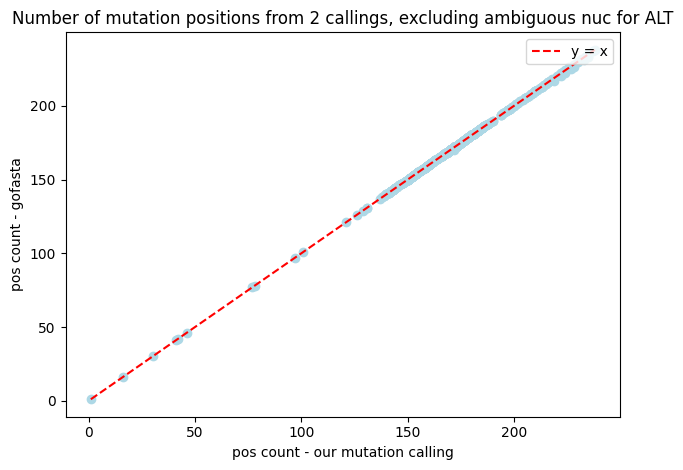

,sra,pos_count_gofasta,pos_count_manual,gap
266,hCoV-19/USA/CA-SEARCH-140393/2024,225,227,2
268,hCoV-19/USA/CA-SEARCH-140651/2024,220,222,2
269,hCoV-19/USA/CA-SEARCH-140767/2024,231,233,2
273,hCoV-19/USA/CA-SEARCH-141236/2024,222,224,2
279,hCoV-19/USA/CA-SEARCH-142409/2024,233,235,2
281,hCoV-19/USA/CA-SEARCH-142947/2024,233,235,2
282,hCoV-19/USA/CA-SEARCH-143126/2025,226,228,2
350,hCoV-19/USA/CA-SEARCH-233272/2024,217,219,2
765,hCoV-19/USA/STM-0000729-E08/2021,170,172,2


In [50]:
pos_mismatch = corr_plt(ba2_gofasta, ba2_manual, "BA2")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_gofasta"]
pos_mismatch.sort_values(by=["gap"], ascending=False)

In [48]:
tmp2 = ba2_manual[(ba2_manual["sra"] == 'hCoV-19/USA/STM-0007062-B10/2021') & (~ba2_manual["alt"].isin(ambiguous_nuc))]
tmp2

,sra,region,pos,ref,alt
343603,hCoV-19/USA/STM-0007062-B10/2021,NC_045512.2,22555,C,T
343606,hCoV-19/USA/STM-0007062-B10/2021,NC_045512.2,22558,C,T
343609,hCoV-19/USA/STM-0007062-B10/2021,NC_045512.2,22561,C,A
343618,hCoV-19/USA/STM-0007062-B10/2021,NC_045512.2,22570,T,C
343621,hCoV-19/USA/STM-0007062-B10/2021,NC_045512.2,22573,A,T
...,...,...,...,...,...
344176,hCoV-19/USA/STM-0007062-B10/2021,NC_045512.2,23128,T,A
344188,hCoV-19/USA/STM-0007062-B10/2021,NC_045512.2,23140,T,A
344191,hCoV-19/USA/STM-0007062-B10/2021,NC_045512.2,23143,A,T
344194,hCoV-19/USA/STM-0007062-B10/2021,NC_045512.2,23146,G,A


In [ ]:
tmp1 = ba1_manual.loc[ba1_manual["sra"] == "hCoV-19/Iraq/KR-SEARCH-119907/2021", ]
tmp2 = ba1_gofasta.loc[ba1_gofasta["sra"] == "hCoV-19/Iraq/KR-SEARCH-119907/2021", ]
m = pd.merge(tmp1, tmp2, on=["sra", "pos"], how="outer", indicator=True)
m[(m["_merge"]== "left_only")&(~m["alt_x"].isin(ambiguous_nuc))]

In [ ]:
tmp1 = ba1_gofasta.loc[ba1_gofasta["sra"] == "hCoV-19/Iraq/KR-SEARCH-118872/2021", ]
tmp2 = ba1_manual.loc[(ba1_manual["sra"] == "hCoV-19/Iraq/KR-SEARCH-118872/2021") & (ba1_manual["alt"] != 'N'), ]
merged_tmp = pd.merge(tmp1, tmp2, how="outer", on=['sra', 'pos'], indicator=True)
merged_tmp.loc[merged_tmp["_merge"] == 'left_only', :]

In [ ]:
corr_plt(ba2_gofasta, ba2_manual, "BA2")

In [ ]:
df1 = pd.read_csv('/home/eleanor124/projects/bjorn_rep/output/Hu1/mutations.tsv', sep="\t", header=0)
df1.sort_values(by=["sra", "pos"]).reset_index(drop=True, inplace=True)

df2 = pd.read_csv('/home/eleanor124/projects/bjorn_rep/output/Hu1/gofasta/BA1/mutations.tsv', sep="\t", header=0)
df2.sort_values(by=["sra", "pos"]).reset_index(drop=True, inplace=True)

df2

## PB2 - DMS

In [ ]:
pb2_gofasta = process(pb2_gofasta_path)
cy_gofasta = process(cy_gofasta_path)

pb2_manual= process(pb2_manual_path)
cy_manual = process(cy_manual_path)

In [ ]:
pos_mismatch = corr_plt(pb2_gofasta, pb2_manual, "PB2")
pos_mismatch

In [ ]:
pos_mismatch = corr_plt(cy_gofasta, cy_manual, "CY(DMS)")
pos_mismatch